In [3]:
from SFC_TF.Fmodel import SFcalculator

In [4]:
import tensorflow as tf

In [5]:
import reciprocalspaceship as rs
import numpy as np

In [23]:
sfcalculator = SFcalculator("../data/4xof.pdb", mtzfile_dir="../data/4xof.mtz", set_experiment=True)

In [24]:
sfcalculator.inspect_data()

Solvent Percentage: 11.0
Grid size: [80, 120, 144]


In [25]:
Fprotein = sfcalculator.Calc_Fprotein(Print=True)

In [26]:
Fsolvent = sfcalculator.Calc_Fsolvent(Print=True, dmin_mask=6.0, dmin_nonzero=3.0)

In [7]:
Fprotein_arr = Fprotein.numpy()
Fsolvent_arr = Fsolvent.numpy()

### Compare with Phenix

In [8]:
Fcalc = rs.read_mtz('../data/4xof_vanilla.mtz')

In [9]:
Fmodel=rs.read_mtz('../data/4xof_ksol1.mtz')

In [10]:
(Fmodel.get_hkls() == Fcalc.get_hkls()).all()

True

In [11]:
calc_mag = Fcalc['FMODEL'].to_numpy()
calc_ph = np.deg2rad(Fcalc['PHIFMODEL'].to_numpy())
Fcalc_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(calc_mag,calc_ph)])

In [12]:
model_mag = Fmodel['FMODEL'].to_numpy()
model_ph = np.deg2rad(Fmodel['PHIFMODEL'].to_numpy())
Fmodel_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(model_mag,model_ph)])

In [13]:
Fmask_complex = Fmodel_complex - Fcalc_complex

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr,spearmanr

def linear_corr(a,b):
    reg = LinearRegression().fit(a.reshape(-1,1),b.reshape(-1,1))
    print("Linear Fit Coeff:", reg.coef_)
    print("R square:", reg.score(a.reshape(-1,1),b.reshape(-1,1)))
    print("Pearsonr:", pearsonr(a,b))
    print("Spearmanr:", spearmanr(a,b))
    
def comp_plot(mag_a, mag_b, ph_a, ph_b, name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=dpi)
    ax[0].plot(mag_a, mag_b, '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Magnitude")

    ax[1].plot(ph_a, ph_b, '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Phase")
    plt.show()
    
def comp_plot_complex(a,b,name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,3,figsize=[15,4], dpi=dpi)
    ax[0].plot(np.real(a), np.real(b), '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Real Part")

    ax[1].plot(np.imag(a), np.imag(b), '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Imaginary Part")

    ax[2].plot(np.abs(a), np.abs(b), '.', alpha=0.4)
    ax[2].set_xlabel(name_a)
    ax[2].set_ylabel(name_b)
    ax[2].set_title("Magnitude")
    plt.show()

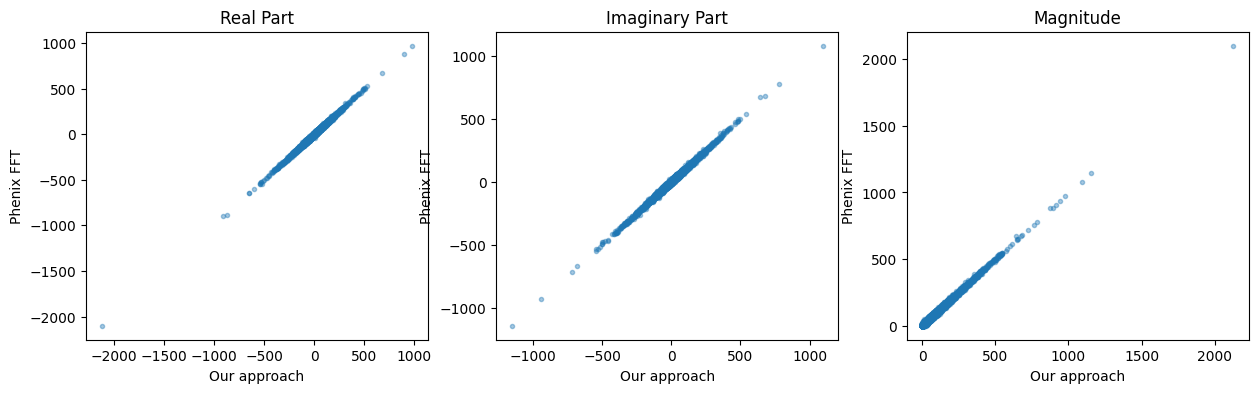

In [15]:
# Protein Part
comp_plot_complex(Fprotein_arr, Fcalc_complex, "Our approach", "Phenix FFT", dpi=100)

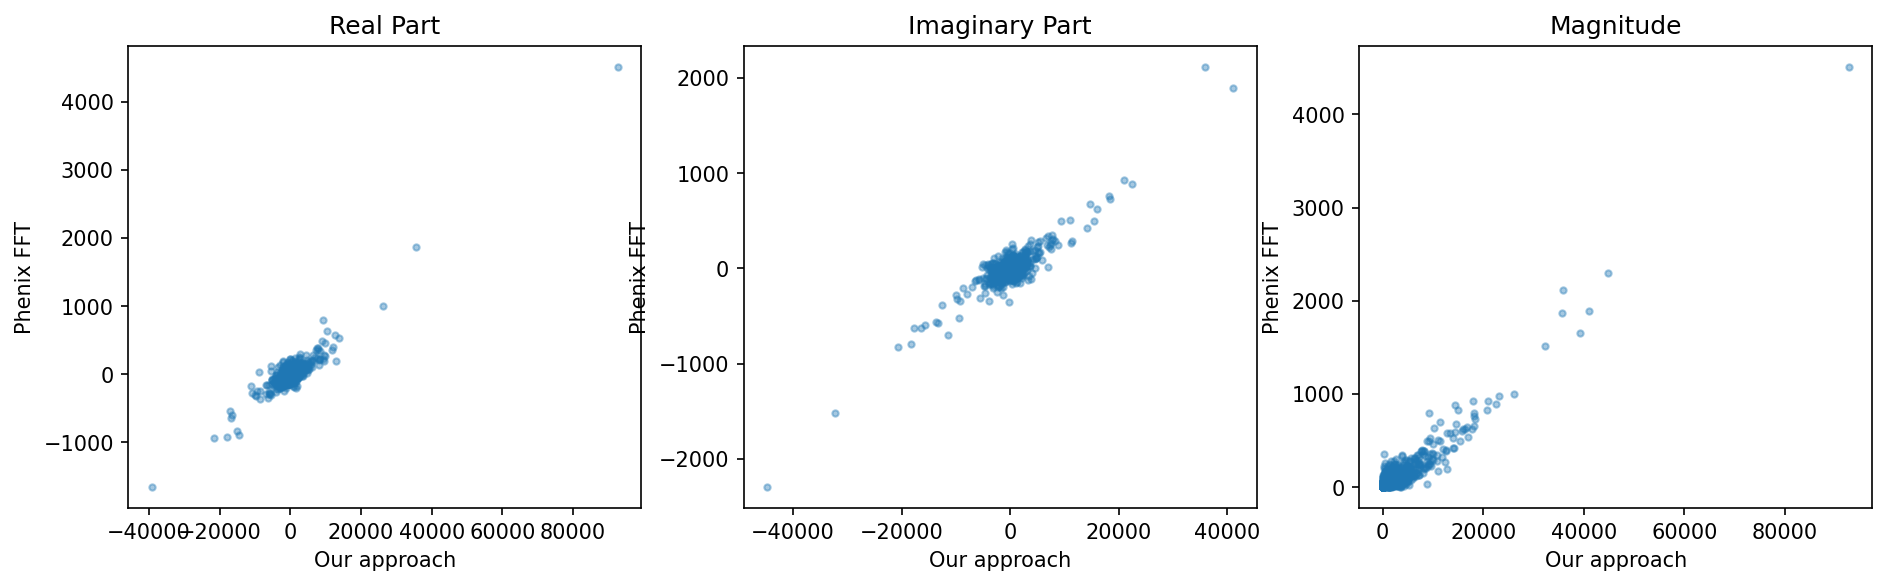

In [16]:
comp_plot_complex(Fsolvent, Fmask_complex, "Our approach", "Phenix FFT", dpi=150)

### Gradient Descent for the scales

In [27]:
from SFC_TF.utils import r_factor
import time

In [32]:
sfcalculator.Calc_Fprotein()
sfcalculator.Calc_Fsolvent(dmin_mask=6, dmin_nonzero=3.0)

In [33]:
def scale_train(optimizer, sfcalculator, n_steps=1000, loss_track=[], verbose=True):
    
    @tf.function(jit_compile=True)
    def scale_steptrain(optimizer, sfcalculator):
        with tf.GradientTape() as tape:
            Fmodel = sfcalculator.Calc_Ftotal(kall=kall, kaniso=kaniso, ksol=ksol, bsol=bsol)
            Fmodel_mag = tf.abs(Fmodel)
            loss = tf.reduce_sum((sfcalculator.Fo - Fmodel_mag)**2)
            r_work, r_free = r_factor(sfcalculator.Fo, Fmodel_mag, sfcalculator.rwork_id, sfcalculator.rfree_id)
        grads = tape.gradient(loss, [kall, kaniso, ksol, bsol])
        optimizer.apply_gradients(zip(grads, [kall, kaniso, ksol, bsol]))
        return loss, r_work, r_free
    
    for k in range(n_steps):
        start_time = time.time()

        temp = scale_steptrain(optimizer, sfcalculator)
        loss_track.append([i.numpy() for i in temp])

        time_this_round = round(time.time() - start_time, 3)
        str_ = "Time: " + str(time_this_round)

        if verbose:
            print("Scale", *loss_track[-1], str_, flush=True)
    
    return loss_track

In [34]:
kall = tf.Variable(0.5)
kaniso = tf.Variable(tf.random.normal([6], mean=0.01, stddev=0.01))
ksol = tf.Variable(0.1)
bsol = tf.Variable(.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [35]:
loss_track = scale_train(optimizer, sfcalculator, n_steps=2000, loss_track=[], verbose=True)

Scale 67556640.0 0.5589064 0.5995399 Time: 1.642
Scale 56908016.0 0.53696024 0.56903034 Time: 0.001
Scale 48550704.0 0.51309013 0.5377448 Time: 0.001
Scale 41754704.0 0.48352927 0.50266874 Time: 0.001
Scale 36093064.0 0.44978455 0.46450165 Time: 0.001
Scale 31452736.0 0.41458437 0.42642942 Time: 0.001
Scale 27546556.0 0.38154987 0.39238197 Time: 0.001
Scale 24317556.0 0.3558898 0.36484656 Time: 0.001
Scale 21843270.0 0.3415754 0.346304 Time: 0.001
Scale 19965010.0 0.33925596 0.3493394 Time: 0.001
Scale 18591130.0 0.34880266 0.3551128 Time: 0.001
Scale 18282836.0 0.36756498 0.37895286 Time: 0.001
Scale 18888064.0 0.39050448 0.40650892 Time: 0.001
Scale 19883726.0 0.41021878 0.42920184 Time: 0.001
Scale 20647910.0 0.42145705 0.44232512 Time: 0.001
Scale 20822812.0 0.4226257 0.44464454 Time: 0.001
Scale 20318842.0 0.41467646 0.43706602 Time: 0.001
Scale 19247912.0 0.39995405 0.4222451 Time: 0.001
Scale 17827516.0 0.3811447 0.4029321 Time: 0.001
Scale 16300820.0 0.36087388 0.3815879 Time: 